In [2]:
!git clone https://github.com/AntonioSkara132/LangPathModel.git

Cloning into 'LangPathModel'...
remote: Enumerating objects: 192, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 192 (delta 10), reused 19 (delta 5), pack-reused 165 (from 1)
Receiving objects: 100% (192/192), 119.55 MiB | 15.80 MiB/s, done.
Resolving deltas: 100% (86/86), done.
Updating files: 100% (77/77), done.


# 1. Loading Dataset

In [3]:
import torch
import torch.utils

from torch.nn.utils.rnn import pad_sequence

from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

scale = 1000

class CirclePathDataset(Dataset):
    def __init__(self, file_path):
        # Load the data from the .pt file
        self.data = torch.load(file_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the path tensor and the text for the given index
        path_tensor = self.data[idx]['path'].clone()
        path_tensor[:, 0:2] /= scale
        text = self.data[idx]['text']
        return path_tensor, text


from torch.nn.utils.rnn import pad_sequence
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def collate_fn(batch):
    # Unzip the batch into paths and texts
    paths, texts = zip(*batch)
    # Pad the paths (ensure they're all the same length)
    padded_paths = pad_sequence(paths, batch_first=True, padding_value=0)  # Padding value can be set to 0

    encoded = tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        return_tensors='pt'
    )

    return padded_paths, encoded


# Instantiate the dataset
dataset = CirclePathDataset("//content/LangPathModel/data/square_paths.pt")

# Create a DataLoader with the custom collate_fn

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# 2. Visualizing Dataset

In [2]:
import torch
import numpy as np

# Assuming you already loaded your dataset
#dataset = CirclePathDataset("/content/LangPathModel/data/circle_in_the middle_num_p_20.pt")

# Containers for analysis
path_lengths = []
positions = []
actions = []
stops = []

for path, _ in dataset:
    path_lengths.append(path.shape[0])  # Sequence length
    path_np = path.numpy()

    positions.extend(path_np[:, :2])  # x, y
    actions.extend(path_np[:, 2])      # a
    stops.extend(path_np[:, 3])      # s

positions = np.array(positions)
actions = np.array(actions)
stops = np.array(stops)

# Summary stats
print(f"Number of samples: {len(dataset)}")
print(f"Avg. path length: {np.mean(path_lengths):.2f}")
print(f"Max path length: {np.max(path_lengths)}")
print(f"Min path length: {np.min(path_lengths)}")
print(f"Position X: mean={positions[:,0].mean():.2f}, std={positions[:,0].std():.2f}")
print(f"Position Y: mean={positions[:,1].mean():.2f}, std={positions[:,1].std():.2f}")
print(f"Actions (a): mean={actions.mean():.2f}, std={actions.std():.2f}")
print(f"Stop (s): mean={stops.mean():.2f}, std={stops.std():.2f}")


Number of samples: 10000
Avg. path length: 164.70
Max path length: 171
Min path length: 160
Position X: mean=0.50, std=0.09
Position Y: mean=0.50, std=0.09
Actions (a): mean=0.96, std=0.20
Stop (s): mean=0.01, std=0.08


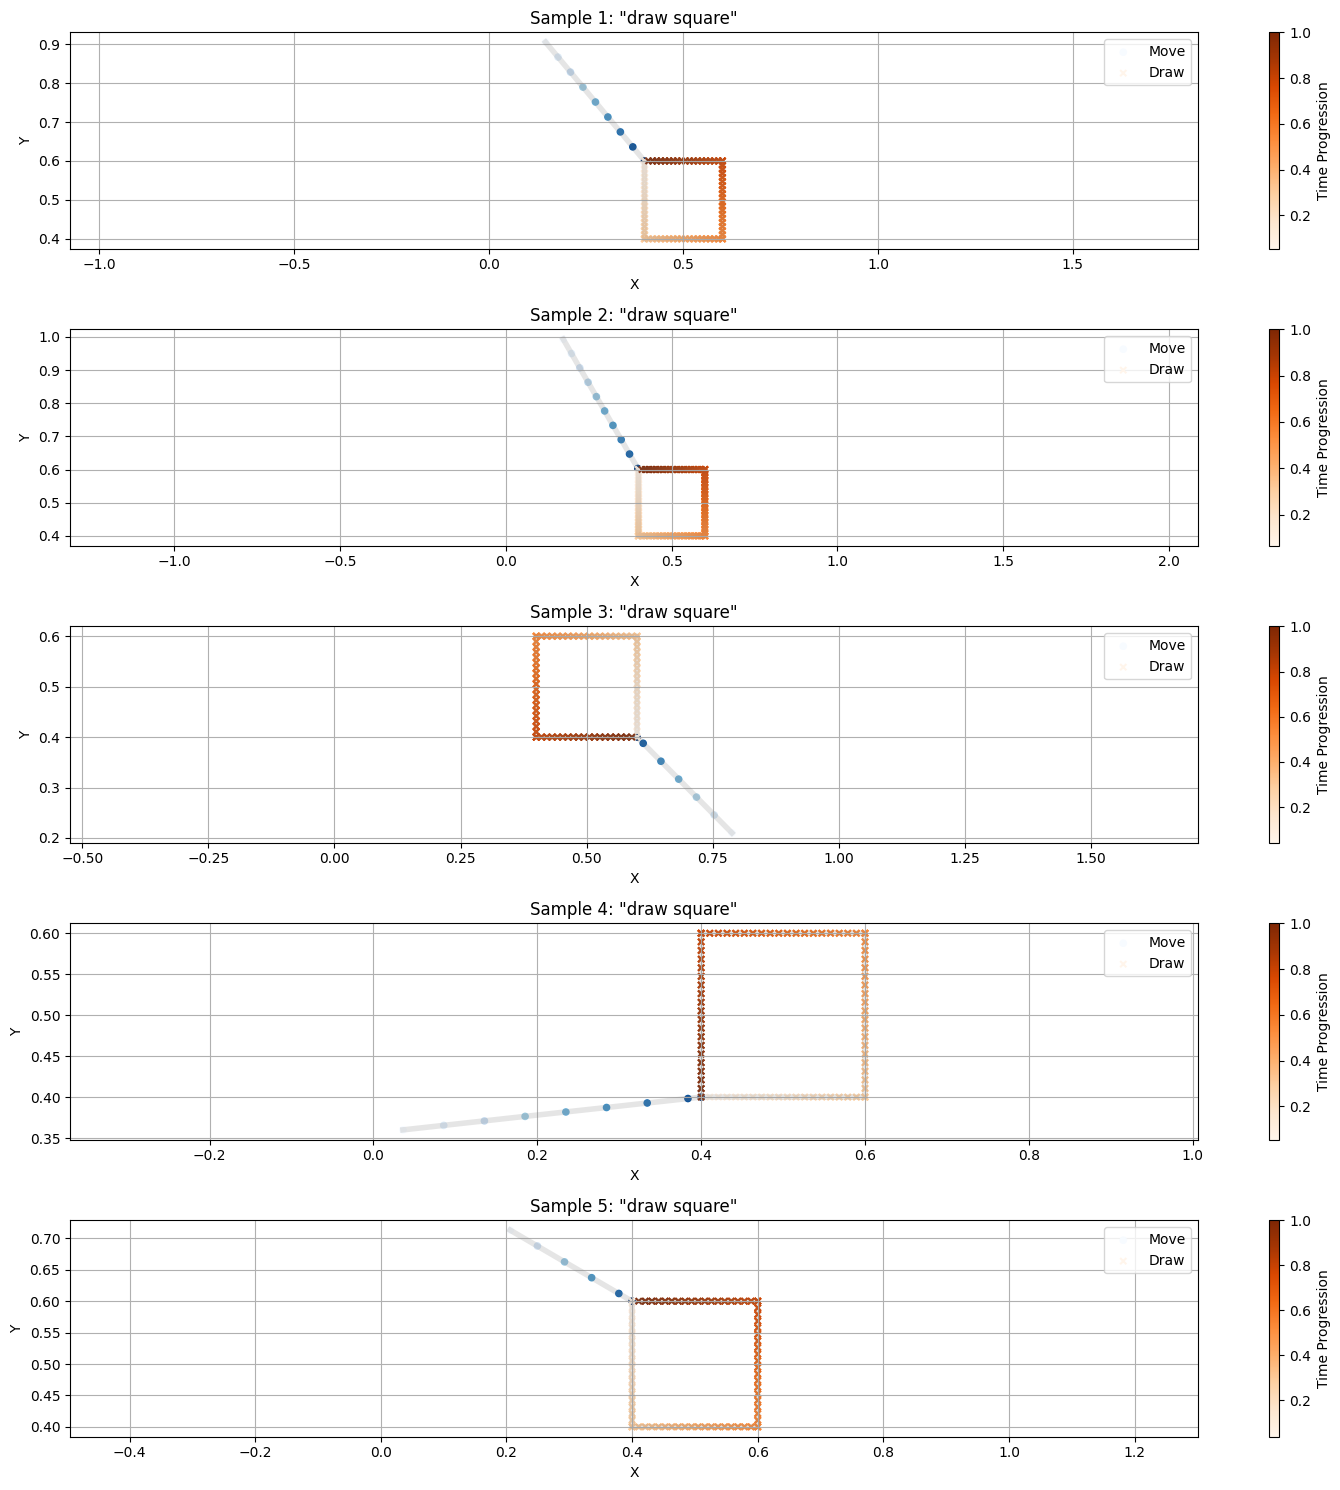

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize a few paths
num_to_plot = 5
plt.figure(figsize=(15, 3 * num_to_plot))

for i in range(num_to_plot):
    path, text = dataset[i]
    path_np = path.numpy()
    #print(path)
    x, y = path_np[:, 0], path_np[:, 1]
    actions = path_np[:, 2]
    time = np.linspace(0, 1, len(x))

    plt.subplot(num_to_plot, 1, i + 1)

    # Separate by action
    move_mask = actions == 0
    draw_mask = actions == 1

    # Plot move points
    move = plt.scatter(x[move_mask], y[move_mask], c=time[move_mask], cmap='Blues', marker='o', s=20, label="Move")
    # Plot draw points
    draw = plt.scatter(x[draw_mask], y[draw_mask], c=time[draw_mask], cmap='Oranges', marker='x', s=20, label="Draw")

    # Optionally plot light path line in background
    plt.plot(x, y, linewidth=4, alpha=0.2, color='gray')

    plt.title(f"Sample {i + 1}: \"{text}\"")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.colorbar(draw, label="Time Progression")  # You can use `move` or `draw`, both have color info
    plt.axis("equal")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


# 3. Training

In [6]:
import torch
from LangPathModel.colab_src.nn import TrajectoryModel
from LangPathModel.colab_src.textEncoders import TextEncoder
from torch.optim.lr_scheduler import StepLR

#data = [Batch, sequence, (batch input, batch target)]

def train(model, dataloader, niter, device, start_lr = 1e-4):
    criterion = model.get_loss  # assumes it returns CrossEntropyLoss with ignore_index for padding
    optimizer = torch.optim.Adam(model.parameters(), lr=start_lr)
    num_batches = len(dataloader)
    #print(f"Number of batches: {num_batches}")
    Scheduler = StepLR(optimizer, step_size = 8, gamma=0.1)
    model.positional_encoding = model.positional_encoding.to(device)
    # The model is already defined outside the train function, no need to redefine it here
    # model = TrajectoryModel()
    model.train()
    #text_encoder = TextEncoder(output_dim=model.d_model)
    #text_encoder.to(device) # Move text_encoder to the device

    for epoch in range(niter):
        total_loss = 0
        index = 0
        for batch_paths, batch_texts in dataloader:
            #print(f"paths: {batch_paths[0]}")
            batch_paths = batch_paths.to(device).float()
            #print(type(batch_paths))
            # Shift target for teacher forcing
            decoder_input = batch_paths[:, :-1].to(device)      # all except last token, move to device
            target_output = batch_paths[:, 1:].to(device)        # all except first token, move to device
            encoder_input = batch_paths[:, 0].unsqueeze(1).to(device) # Move encoder_input to the device
            #print(target_output)

            encoder_input_mask = (encoder_input.abs().sum(dim=-1) != 0).bool().reshape(-1, 1).to(device)
            #print(f"encoder_input_mask: {encoder_input_mask.shape}")
            #print(f"encoder_input: {encoder_input.shape}"
            #emb_text = text_encoder(batch_texts['input_ids'].to(device), batch_texts['attention_mask'].to(device)) # Pass tensors on the device
            text_mask = batch_texts['attention_mask'] == 0
            text = batch_texts['input_ids']
            optimizer.zero_grad()
            #print(f"encoder input mask: {encoder_input_mask.shape}")
            #print(f"encoder_input: {encoder_input.shape}")

            text = text.to(device).long()
            text_mask = text_mask.to(device).bool()

            predictions = model(text = text, path = encoder_input, path_mask = encoder_input_mask, tgt = decoder_input, text_mask=text_mask)  # shape: [B, T]
            # Reshape for loss: CrossEntropy wants [B*T, vocab_size] vs [B*T]

            #predictions = predictions.reshape(-1, predictions.size(-1))
            #print("predictions:", predictions.shape)        # should be [32, 199, 512]
            #print("target_output:", target_output.shape)    # should be the same

            loss = criterion(predictions, target_output)#fix this
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            #print(loss.item())
            #print(index)


        Scheduler.step()
        print(f"Epoch {epoch+1} | Loss: {(total_loss/num_batches):.4f}")



In [1]:
import torch
import torch.utils

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from LangPathModel.colab_src.nn import TrajectoryModel
from torch.utils.data import ConcatDataset


#from LangPathModel.colab_src.dataset_preprocessing import CirclePathDataset, collate_fn

# Instantiate the dataset
dataset1 = CirclePathDataset("/content/LangPathModel/data/circle_in_the middle_num_p_20.pt")
dataset2 = CirclePathDataset("//content/LangPathModel/data/square_paths.pt")

dataset = ConcatDataset([dataset1, dataset2])

# Create a DataLoader with the custom collate_fn
dataloader = DataLoader(dataset, batch_size=100, collate_fn=collate_fn, shuffle=True)

model = TrajectoryModel(d_model = 128, num_heads_decoder = 8, num_decoder_layers = 2)
#print(model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)
for name, param in model.named_parameters():
    print(f"{name}: {param.device}")


train(model = model, niter = 20, dataloader = dataloader, device = device, start_lr = 1e-4)
model.to('cpu')
torch.save(model.state_dict(), 'model_state_dict_dec_5_head_8_sq_and_ci.pth')


ModuleNotFoundError: No module named 'LangPathModel'

# Training by grid search

In [ ]:
import torch
from torch.utils.data import DataLoader
from LangPathModel.colab_src.nn import TrajectoryModel
from torch.utils.data import ConcatDataset
# from LangPathModel.colab_src.dataset_preprocessing import CirclePathDataset, collate_fn

# Parameters to grid search over
decoder_heads_list = [4, 8]
decoder_layers_list = [2, 3, 4, 6, 8]

# Dataset + Dataloader
dataset1 = CirclePathDataset("/content/LangPathModel/data/circle_in_the middle_num_p_20.pt")
dataset2 = CirclePathDataset("//content/LangPathModel/data/square_paths.pt")

dataset = ConcatDataset([dataset1, dataset2])

dataloader = DataLoader(dataset, batch_size=100, shuffle=True, collate_fn=collate_fn)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Training loop over grid
for heads in decoder_heads_list:
    for layers in decoder_layers_list:
        print(f"\n🔧 Training model with decoder_heads={heads}, decoder_layers={layers}")

        # Initialize model
        model = TrajectoryModel(d_model=128, num_heads_decoder=heads, num_decoder_layers=layers)
        model = model.to(device)

        # Train the model
        train(model=model, niter=12, dataloader=dataloader, device=device, start_lr=1e-4)

        # Save trained model to CPU
        model = model.to('cpu')
        save_path = f'model_dec_{layers}_heads_{heads}.pth'
        torch.save(model.state_dict(), save_path)
        print(f"✅ Saved: {save_path}")


Using device: cuda

🔧 Training model with decoder_heads=4, decoder_layers=2
Epoch 1 | Loss: 0.0299
Epoch 2 | Loss: 0.0047
Epoch 3 | Loss: 0.0031
Epoch 4 | Loss: 0.0025
Epoch 5 | Loss: 0.0023
Epoch 6 | Loss: 0.0021
Epoch 7 | Loss: 0.0020
Epoch 8 | Loss: 0.0020
Epoch 9 | Loss: 0.0020
Epoch 10 | Loss: 0.0020
Epoch 11 | Loss: 0.0020
Epoch 12 | Loss: 0.0020
✅ Saved: model_dec_2_heads_4.pth

🔧 Training model with decoder_heads=4, decoder_layers=3
Epoch 1 | Loss: 0.0247


tensor(0.0059, device='cuda:0')
tensor(0.0068, device='cuda:0')
tensor(0.0039, device='cuda:0')
tensor(-0.0090, device='cuda:0')
tensor(-0.0395, device='cuda:0')
tensor(-0.0230, device='cuda:0')
tensor(0.0048, device='cuda:0')
tensor(0.0301, device='cuda:0')
tensor(0.0271, device='cuda:0')
tensor(0.0067, device='cuda:0')
tensor(0.0035, device='cuda:0')
tensor(-0.0126, device='cuda:0')
tensor(-0.0167, device='cuda:0')
tensor(-0.0199, device='cuda:0')
tensor(-0.0164, device='cuda:0')
tensor(-0.0118, device='cuda:0')
tensor(-0.0216, device='cuda:0')
tensor(-0.0220, device='cuda:0')
tensor(-0.0217, device='cuda:0')
tensor(-0.0164, device='cuda:0')
tensor(-0.0088, device='cuda:0')
tensor(-0.0122, device='cuda:0')
tensor(-0.0094, device='cuda:0')
tensor(-0.0111, device='cuda:0')
tensor(-0.0112, device='cuda:0')
tensor(-0.0137, device='cuda:0')
tensor(-0.0220, device='cuda:0')
tensor(-0.0166, device='cuda:0')
tensor(-0.0120, device='cuda:0')
tensor(-0.0079, device='cuda:0')
tensor(-0.0018, de

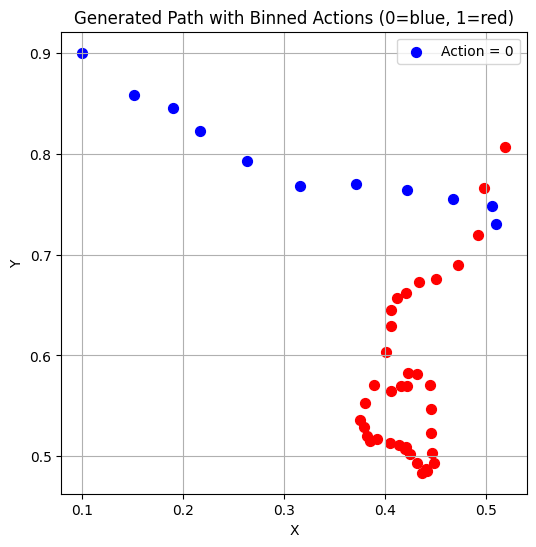

In [41]:
import torch
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
from LangPathModel.colab_src.textEncoders import TextEncoder
from transformers import AutoTokenizer

d_model = 128
model = TrajectoryModel(d_model=d_model, num_heads_decoder=8, num_decoder_layers=4)

# Step 2: Load the saved state dict
model.load_state_dict(torch.load('model_state_dict_dec_2_head_8_sq_and_ci.pth', map_location='cuda' if torch.cuda.is_available() else 'cpu'))

# Step 3: Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.positional_encoding = model.positional_encoding.to(device)  # This line was added

# Initialize tokenizer and encoder
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
text_encoder = TextEncoder(output_dim=d_model)

# Text and encoding
text = "circling"
encoded = tokenizer(text, padding=True, truncation=True, return_tensors='pt')

# **Instead of directly using text_encoder output, use encoded['input_ids'] and encoded['attention_mask']**
# txt = text_encoder(encoded['input_ids'], encoded['attention_mask'])
txt = encoded['input_ids'].to(device)
txt_mask = (encoded['attention_mask'] == 0).to(device)


path_mask = torch.Tensor([[1]]).to(device)

# Iniptialize starting point
start = torch.Tensor([[[0.1, 0.9, 0, 0]]]).to(device)  # (1, 1, 4)
#tgt = torch.empty([1, 1, 4]).to(device)  # (1, 1, 4)
tgt = start
# Store predictions
positions = [start[0, 0, :2].clone().cpu().numpy()]

# Loop to generate 100 predictions
for i in range(200):
    with torch.no_grad():
        prediction = model(
            text=txt,
            path=start,
            tgt=tgt,
            text_mask=txt_mask,
            path_mask=path_mask
        )  # Output shape: (1, seq_len+1, 4
    next_point = prediction[:, -1, :]  # Get the last predicted point
    #print(next_point)
    positions.append(next_point[0, :2].cpu().numpy())  # Save (x, y)

    # Append next_point to tgt for next prediction
    tgt = torch.cat([tgt, next_point.unsqueeze(1)], dim=1)
    if next_point[0, 3] > 0.12: break
    print(next_point[0, 3])

# Convert predictions to numpy array
positions = np.array(positions)  # shape: (num_points, 2)
actions = tgt[0, :, 2].cpu().numpy()  # shape: (num_points,) - only 'a' values
#print(positions)
# Bin actions
binned_actions = (actions >= 0.5).astype(int)  # 0 if a < 0.5, 1 otherwise

# Plot
plt.figure(figsize=(8, 6))
for i in range(len(positions)):
    x, y = positions[i]
    if binned_actions[i] == 0:
        plt.scatter(x, y,color='blue', label='Action = 0' if i == 0 else "", s=50)
    else:
        plt.scatter(x, y, color='red', label='Action = 1' if i == 0 else "", s=50)

plt.title("Generated Path with Binned Actions (0=blue, 1=red)")
plt.xlabel("X")
plt.ylabel("Y")

plt.legend()
plt.gca().set_aspect('equal')
plt.grid(True)
plt.show()



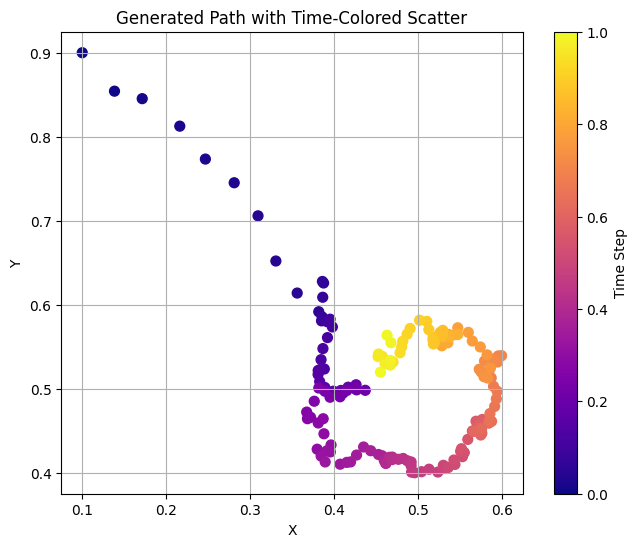

In [37]:
positions = np.array(positions)  # shape: (num_points, 2)
colors = np.linspace(0, 1, len(positions))  # Normalized color values for time

# Scatter plot with color based on time
plt.figure(figsize=(8, 6))
plt.scatter(positions[:, 0], positions[:, 1], c=colors, cmap='plasma', s=50)
plt.colorbar(label="Time Step")
plt.title("Generated Path with Time-Colored Scatter")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().set_aspect('equal')
plt.grid(True)
plt.show()
